In [1]:
%load_ext autoreload
%autoreload 2

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

# RANDOM_SEED = [1,2,3,4,5,6,7,4399,114514,1234]
RANDOM_SEED = [1]
BATCH_SIZE = 32
LEARN_RATE = 0.001
MAX_NUM_EPOCH = 200
VISUALIZE_MODEL = False

Current device: cuda


In [2]:
from models.CSAPredictor import CSAPredictor
from torchview import draw_graph

model = CSAPredictor()
model.to(device)

if VISUALIZE_MODEL:
    model_graph = draw_graph(
        model,
        input_size=[(BATCH_SIZE, 84), (BATCH_SIZE, 4)],
        expand_nested=True)
    display(model_graph.visual_graph)

Outcome Columns: Index(['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score'],
      dtype='object')
Info Columns: Index(['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina'],
      dtype='object')
# of total CSA samples: 1058
# of total subjects: 340


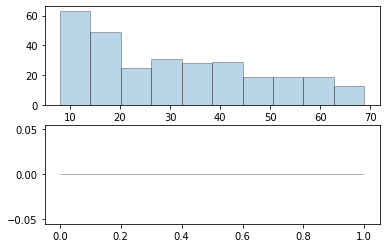

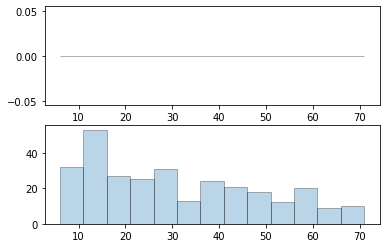

# of valid CSA samples w/o NaN: 295
# of subjects w/ valid CSA samples: 96
# of healthy samples: 295
# of asthma sampels: 0
Outcome Columns: Index(['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score'],
      dtype='object')
Info Columns: Index(['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina'],
      dtype='object')
# of total CSA samples: 1058
# of total subjects: 340


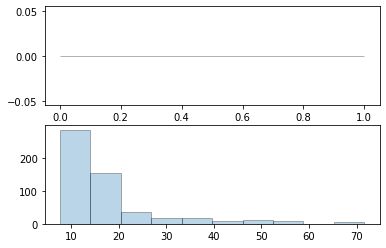

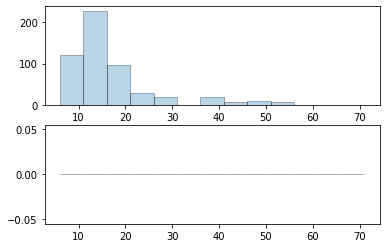

# of valid CSA samples w/o NaN: 542
# of subjects w/ valid CSA samples: 171
# of healthy samples: 0
# of asthma sampels: 542


In [3]:
from data.aware import AwareDataset, KFoldSplitter
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

dataset_healthy = AwareDataset(
    csv_data = 'data/exhale_data_v8_ave.csv',
    csv_outcome = 'data/exhale_outcome_v8_ave.csv',
    csv_info = 'data/exhale_verbose_v8_ave.csv',
    root_dir = 'data/',
    target_classes = [0],
    normalize = False
)

dataset_asthma = AwareDataset(
    csv_data = 'data/exhale_data_v8_ave.csv',
    csv_outcome = 'data/exhale_outcome_v8_ave.csv',
    csv_info = 'data/exhale_verbose_v8_ave.csv',
    root_dir = 'data/',
    target_classes = [1],
    normalize = False
)

Seed 1 | Fold #0


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Test Healthy:


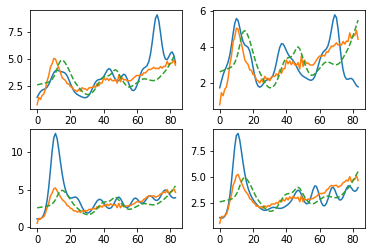

Loss:  tensor(1.1555, device='cuda:0')
Test Asthma:


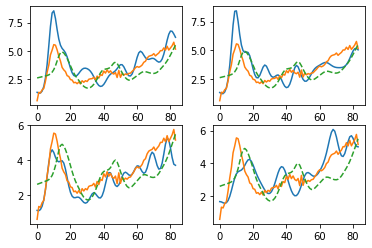

Loss:  tensor(1.2786, device='cuda:0')
Seed 1 | Fold #1


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Test Healthy:


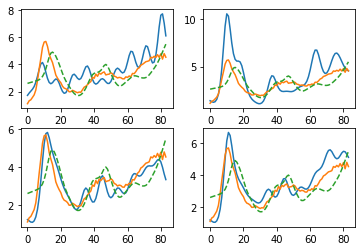

Loss:  tensor(0.9855, device='cuda:0')
Test Asthma:


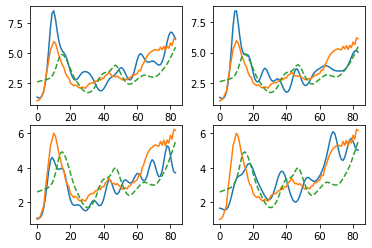

Loss:  tensor(1.3435, device='cuda:0')
Seed 1 | Fold #2


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Test Healthy:


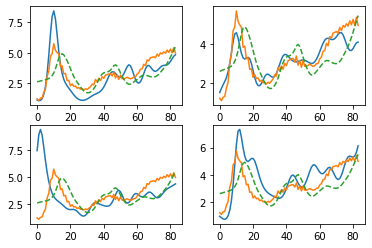

Loss:  tensor(1.4301, device='cuda:0')
Test Asthma:


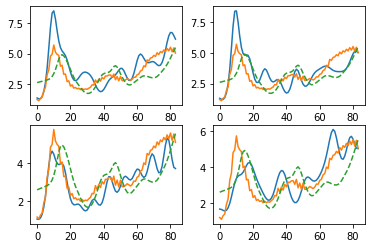

Loss:  tensor(1.2539, device='cuda:0')
Seed 1 | Fold #3


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Test Healthy:


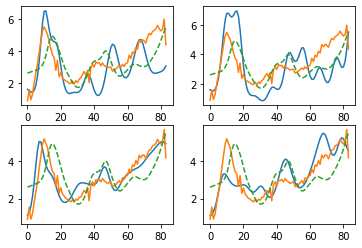

Loss:  tensor(1.0471, device='cuda:0')
Test Asthma:


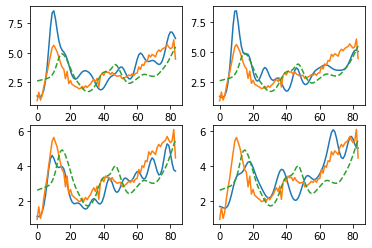

Loss:  tensor(1.3311, device='cuda:0')
Seed 1 | Fold #4


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Test Healthy:


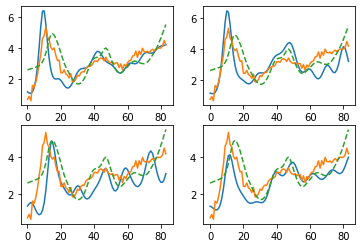

Loss:  tensor(1.1834, device='cuda:0')
Test Asthma:


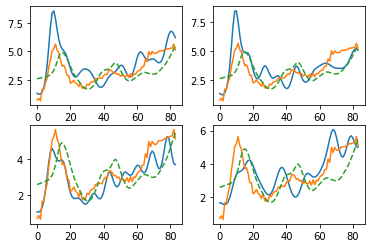

Loss:  tensor(1.2990, device='cuda:0')


In [4]:
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import time
import jupyter_beeper

from trainer.standard import Trainer
from utils.others import weight_reset, Metrics, Outputs
from utils.clustering import evaluate
from utils.outlier import novelty_detection

# metrics_cluster = np.zeros((5,3,3))
metrics_val = Metrics()
metrics_test = Metrics()
outputs_test = Outputs()
loss_healthy = torch.Tensor([])
loss_asthma = torch.Tensor([])

beeper = jupyter_beeper.Beeper()

for rand_seed in RANDOM_SEED:
    splitter = KFoldSplitter(dataset_healthy, BATCH_SIZE, random_seed=rand_seed)
    test_loader_asthma = torch.utils.data.DataLoader(dataset_asthma, batch_size=len(dataset_asthma))

    timestr = time.strftime("%Y%m%d-%H%M%S")
    for split_idx, (train_loader, test_loader) in enumerate(splitter):
        writer = SummaryWriter("runs/" + timestr + "-fold" + str(split_idx))
        model.apply(weight_reset)
        
#         clear_output(wait=True)
        print("Seed " + str(rand_seed) + " | Fold #" + str(split_idx))
        trainer = Trainer(
            model,
            lr = LEARN_RATE,
            T_max = MAX_NUM_EPOCH,
            device = device,
            summarywriter = writer
        )
        for epoch in tqdm(range(MAX_NUM_EPOCH), unit_scale=True, unit="epoch"):
            trainer.train(epoch, train_loader)
            trainer.validate(epoch, test_loader)
        
        print("Test Healthy:")
        trainer.test(test_loader, no_print=True)
        mse = (trainer.outputs-trainer.inputs).square().mean(dim=1)
        loss_healthy = torch.concat((loss_healthy, mse), dim=0)
        print("Test Asthma:")
        trainer.test(test_loader_asthma, no_print=True)
        mse = (trainer.outputs-trainer.inputs).square().mean(dim=1)
        loss_asthma = torch.concat((loss_asthma, mse), dim=0)

#     beeper.beep(frequency=600, secs=0.5)
#     novelty_detection(model, train_loader, val_loader, test_loader)
#     metrics_cluster[split_idx,:,:] = evaluate(model, train_loader, val_loader, test_loader)    


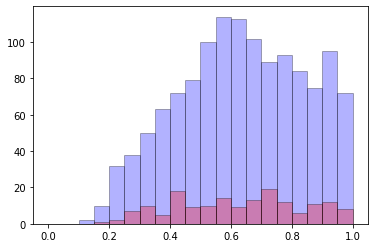

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(loss_asthma.numpy(), bins=20, range=(0,1), alpha = 0.3, color='b', edgecolor='k', linewidth=1)
plt.hist(loss_healthy.numpy(), bins=20, range=(0,1), alpha = 0.3, color='r', edgecolor='k', linewidth=1)
# plt.legend(['Healthy', 'Asthma'])
plt.show()